See script from Keras [here](https://github.com/fchollet/keras/blob/4ec84541e3a33f906d49a3a58f5d249296a62c76/examples/lstm_text_generation.py)

In [1]:
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.datasets.data_utils import get_file
import numpy as np
import random
import sys

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [3]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600901


In [4]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 59


In [5]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 200294


In [6]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [7]:
print(X.shape)
print(y.shape)

(200294, 20, 59)
(200294, 59)


In [8]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Build model...


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Couldn't import dot_parser, loading of dot files will not be possible.


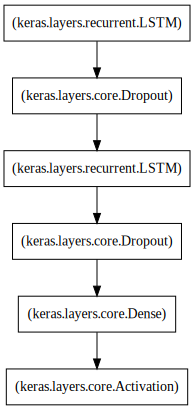

In [14]:
# from keras.utils.visualize_util import plot
# plot(model, to_file='model.png')

from IPython.display import SVG
from keras.utils.visualize_util import to_graph

SVG(to_graph(model).create(prog='dot', format='svg'))

In [10]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

In [11]:
# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
160000/200294 [======================>.......] - ETA: 614s - loss: 2.8295

KeyboardInterrupt: 